# Transformer架构
<img src="https://cdn.acwing.com/media/article/image/2025/05/05/291897_78bad9d529-%E5%B1%8F%E5%B9%95%E6%88%AA%E5%9B%BE-2025-05-05-150525.png" width=300px>

## 位置编码（Positional Encoding
- 功能：为输入序列添加位置信息（如词的位置1、2、3…），弥补自注意力机制本身对顺序不敏感的缺陷。
- 实现方式：
    - 偶数位置编码公式：$PE_{pos,2i}=\sin{\dfrac{pos}{10000^{\frac{2i}{d_{model}}}}}$
    - 奇数位置编码公式：$PE_{pos,2i+1}=\cos{\dfrac{pos}{10000^{\frac{2i}{d_{model}}}}}$
- 优点：
    - 显式引入位置信息，使模型能区分序列的顺序。
    - 正弦/余弦编码可泛化到比训练时更长的序列。

In [1]:
from torch import nn, Tensor
import torch

class PositionEncoding(nn.Module):
    """
    将输入的token进行位置编码
    用固定的正余弦函数为每个位置生成一个唯一的向量。
    """
    def __init__(self, d_model:int, max_seq_len:int = 512) -> None:
        """
            初始化位置编码变量 shape = [batch_size, seq_len, d_model]
            :d_model: 位置编码的维度
            :max_seq_len: 序列最大长度
        """
        super().__init__()
        pos = torch.arange(0, max_seq_len).unsqueeze(1) # [max_seq_len, 1]
        tmp = 1 / (10000**(torch.arange(0, d_model, 2) / d_model)) # [1, d_model // 2]
        pos_tmp = pos * tmp # [max_seq_len, d_model // 2]
        
        pe= torch.zeros(max_seq_len, d_model)
        pe[:, 0::2] = torch.sin(pos_tmp)
        pe[:, 1::2] = torch.cos(pos_tmp)
        pe = pe.unsqueeze(0) # [1, max_seq_len, d_model]
        self.register_buffer("pe", pe) # # 注册为 buffer（模型保存时也会保存，但不会更新梯度）
        

    def forward(self, x: Tensor) -> Tensor:
        """
            :x: 需要位置编码的token shape = [batch, seq, d_model]
            :return: (batch, 序列, 位置编码)
        """
        batch_size, seq_len, _ = x.shape
        pe = self.pe # 位置编码，为常量
        return x + pe[:, :seq_len, :] #batch, 输入token, 位置编码

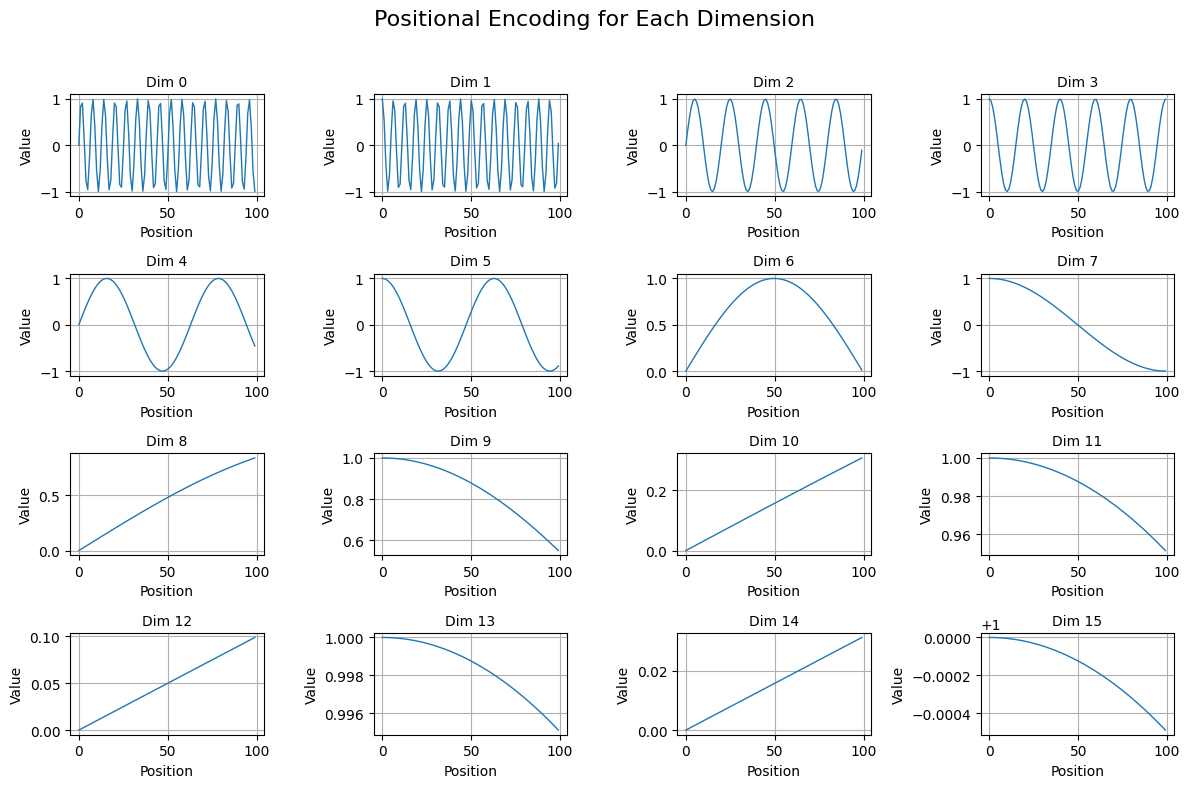

In [2]:
import matplotlib.pyplot as plt
d_model = 16
max_seq_len = 100
pos_encoder = PositionEncoding(d_model=d_model, max_seq_len=max_seq_len)
pe = pos_encoder.pe[0]  # [max_seq_len, d_model]

# 创建子图画布
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 8))
fig.suptitle("Positional Encoding for Each Dimension", fontsize=16)

for i in range(d_model):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    ax.plot(pe[:, i].numpy(), linewidth=1)
    ax.set_title(f"Dim {i}", fontsize=10)
    ax.set_xlabel("Position")
    ax.set_ylabel("Value")
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

## 多头注意力机制
- 功能：计算输入序列中所有词之间的相关权重，捕捉全局依赖关系
- 核心公式：$$Attention(Q,K,V)=softmax(\dfrac{QK^T}{\sqrt{d_k}})V$$
    - 其中，Q(Query), K(Key), V(Value)由输入向量线性变换得到
- 多头机制：将Q, K, V拆分为多个子空间，分别计算注意力后拼接结果
- 优点：
    - 并行计算：自注意力机制天然适合并行化，显著提升训练速度
    - 长距离依赖：直接建模任意两个词的关系，解决RNN的长程梯度消失问题
    - 多样性：不同注意力头关注不同模式（如语法、语义、代指关系）

In [3]:
import math
from typing import Union

class ScaleDotProductAttention(nn.Module):
    """
        计算缩放点击注意力分数（单头注意力）
    """
    def __init__(self) -> None:
        super().__init__()
        self.softmax = nn.Softmax(dim=-1) # 在列上做Softmax，每一行的和为1

    def forward(self, q: Tensor, k: Tensor, v: Tensor, mask: Union[None, Tensor] = None) -> Tensor:
        """
            将输入的q,k,v计算对应的注意力分数
            query, key, value的shape为：[batch_size, heads, seq_len, d_tensor]
        """
        batch_size, heads, seq_key_len, d_tensor = k.shape
        k_t = k.transpose(-2, -1)
        att_ = (q @ k_t) / math.sqrt(d_tensor)

        if mask is not None:
            att_ = att_.masked_fill(mask, -1e9) # 将需要掩码的地方赋给一个超小的值，使其在后续操作中不起作用
            
        att_ = self.softmax(att_)
        att_score: Tensor = att_ @ v
        return att_score

class MultiHeadAttention(nn.Module):
    """
        计算多头注意力机制
    """
    def __init__(self, heads: int, d_model: int, drop_out: float = 0.1) -> None:
        super().__init__()
        assert d_model % heads == 0, "d_model % heads != 0, 无法将注意力头正分"
        self.attention = ScaleDotProductAttention()
        self.heads = heads
        self.w_q = nn.Linear(d_model, d_model) # Q = Aq
        self.w_k = nn.Linear(d_model, d_model) # K = Ak
        self.w_v = nn.Linear(d_model, d_model) # V = Av
        self.w_concat = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(drop_out)
        
    def forward(self, q: Tensor, k: Tensor, v: Tensor, mask: Union[None, Tensor] = None) -> Tensor:
        """
            将输入的q，k，v分成多头后计算注意力分数
            query, key, value的shape为: [batch_size, seq_len, d_model]
        """
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)
        q, k, v = self.split(q), self.split(k), self.split(v)
        out = self.attention(q, k, v, mask = mask)
        out = self.concat(out)
        out = self.w_concat(out)
        out = self.dropout(out)

        return out

    def split(self, x: Tensor) -> Tensor:
        """
            将q，k，v分为多个头
            x的shape为 [batch_size, seq_len, d_model]
            return [batch_size, heads, seq_len, d_tensor]
        """
        batch_size, seq_len, d_model = x.shape
        d_tensor = d_model // self.heads
        return x.reshape(batch_size, seq_len, self.heads, d_tensor).transpose(1, 2) 
        # 为什么不能直接写成 reshape(batch_size, self.heads, seq_len, d_tensor)？
        # 因为先将其reshape是将[batch_size, seq_len, d_model] => [batch_size, seq_len, self.heads, d_tensor]可以使 
        # [d_model] => [self.heads, d_tensor]保证这两个维度的数据是d_model进行reshape过来的
        # reshape(batch_size, self.heads, seq_len, d_tensor)而这样写就让数据错乱，不好进行concat

    def concat(self, x: Tensor) -> Tensor:
        """
            将多头的内容进行合并
            x的shape为[batch_size, heads, seq_len, d_tensor]
            return [batch_size, seq_len, d_model]
        """
        batch_size, heads, seq_len, d_tensor = x.shape
        d_model = heads * d_tensor
        return x.transpose(1, 2).reshape(batch_size, seq_len, d_model)

In [4]:
class FeedForward(nn.Module):
    """
        transformer中的前向传播层
    """
    def __init__(self, d_model: int, d_ffn: int, drop_out: float = 0.1) -> None:
        """
            经过线性层，激活函数，正则化等操作
        """
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ffn),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(d_ffn, d_model),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.ffn(x)    

In [5]:
class EncoderLayer(nn.Module):
    """
        transformer的编码器模块
    """
    def __init__(self, heads: int, d_model: int, d_ffn: int, drop_out: float = 0.1) -> None:
        super().__init__()
        self.multi_head_att = MultiHeadAttention(heads, d_model, drop_out)
        self.ffn = FeedForward(d_model, d_ffn, drop_out)
        self.norms = nn.ModuleList([nn.LayerNorm(d_model) for i in range(2)]) #列表，用于存储，不自动调用forward
        self.dropout = nn.Dropout(drop_out)

    def forward(self, x: Tensor, mask: Union[None, Tensor] = None) -> Tensor:
        """
            将输入token送入多头注意力，正则化+残差，前馈传输，正则化+残差
        """
        out1 = self.multi_head_att(x, x, x, mask)
        out1 = self.norms[0](out1 + x)
        out2 = self.ffn(out1)
        out2 = self.norms[1](out2 + out1)
        out = self.dropout(out2)
        
        return out

class Encoder(nn.Module):